## Real time linkage

In this notebook, we demonstrate splink's incremental and real time linkage capabilities - specifically:
- the `linker.compare_two_records` function, that allows you to interactively explore the results of a linkage model; and
- the `linker.find_matches_to_new_records` that allows you to incrementally find matches to a small number of new records

### Step 1: Load a pre-trained linkage model

In [1]:
import pandas as pd
import json
from splink.duckdb.duckdb_linker import DuckDBLinker
import altair as alt
alt.renderers.enable('mimetype')

with open("demo_settings/real_time_settings.json") as f:
    trained_settings = json.load(f)

df = pd.read_csv("./data/fake_1000.csv")

linker = DuckDBLinker(df, trained_settings)
linker._initialise_df_concat_with_tf()
linker.compute_tf_table("first_name")
linker.compute_tf_table("surname")
linker.compute_tf_table("dob")
linker.compute_tf_table("city")
t = linker.compute_tf_table("email")

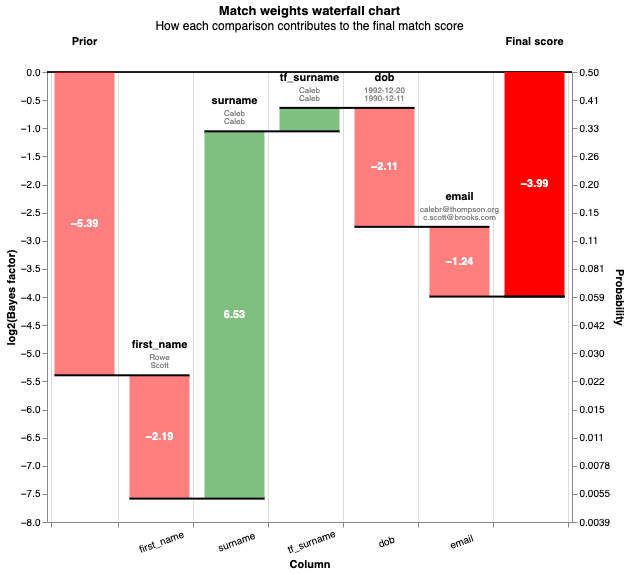

In [2]:
linker.waterfall_chart(linker.predict().as_record_dict(limit=2))

### Step  Comparing two records

It's now possible to compute a match weight for any two records using `linker.compare_two_records()`

In [3]:
record_1  = {
     'unique_id':1,
     'first_name': "Lucas",
     'surname': "Smith",
     'dob': "1984-01-02",
     'city': "London",
     'email': "lucas.smith@hotmail.com"
}

record_2  = {
     'unique_id':2,
     'first_name': "Lucas",
     'surname': "Smith",
     'dob': "1983-02-12",
     'city': "Machester",
     'email': "lucas.smith@hotmail.com"
}
linker._settings_obj_._retain_intermediate_calculation_columns = True
linker._settings_obj_._retain_matching_columns = True

df_two = linker.compare_two_records(record_1, record_2)
df_two.as_pandas_dataframe()

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,tf_first_name_l,tf_first_name_r,bf_first_name,...,tf_city_r,bf_city,bf_tf_adj_city,email_l,email_r,gamma_email,tf_email_l,tf_email_r,bf_email,bf_tf_adj_email
0,13.161672,0.999891,1,2,Lucas,Lucas,2,0.001203,0.001203,87.571229,...,NaN,0.446404,1.0,lucas.smith@hotmail.com,lucas.smith@hotmail.com,1,NaN,NaN,263.229168,1.0


### Step 3: Interactive comparisons

One interesting applicatin of `compare_two_records` is to create a simple interface that allows the user to input two records interactively, and get real time feedback.

In the following cell we use `ipywidets` for this purpose.  ✨✨ Change the values in the text boxes to see the waterfall chart update in real time. ✨✨

In [4]:
import ipywidgets as widgets
fields = ["unique_id", "first_name","surname","dob","email","city"]

left_text_boxes = []
right_text_boxes = []

inputs_to_interactive_output = {}

for f in fields:
    wl = widgets.Text(description=f, value =str(record_1[f]))
    left_text_boxes.append(wl)
    inputs_to_interactive_output[f"{f}_l"] = wl
    wr = widgets.Text( description=f, value =str(record_2[f]))
    right_text_boxes.append(wr)
    inputs_to_interactive_output[f"{f}_r"] = wr


b1 = widgets.VBox(left_text_boxes)
b2 = widgets.VBox(right_text_boxes)
ui = widgets.HBox([b1,b2])

def myfn(**kwargs):
    my_args = dict(kwargs)
    
    record_left = {}
    record_right = {}
    
    for key, value in my_args.items():
        if value == '':
            value = None
        if key.endswith("_l"):
            record_left[key[:-2]] = value
        if key.endswith("_r"):
            record_right[key[:-2]] = value
            

    linker._settings_obj_._retain_intermediate_calculation_columns = True
    linker._settings_obj_._retain_matching_columns = True

    df_two = linker.compare_two_records(record_left, record_right)

    recs = df_two.as_pandas_dataframe().to_dict(orient="records")
    from splink.charts import waterfall_chart
    display(linker.waterfall_chart(recs, filter_nulls=False))


out = widgets.interactive_output(myfn, inputs_to_interactive_output)

display(ui,out)


Output()

## Finding matching records interactively

It is also possible to search the records in the input dataset rapidly using the `linker.find_matches_to_new_records()` function

In [5]:
record = {'unique_id': 123987,
 'first_name': "Robert",
 'surname': "Alan",
 'dob': "1971-05-24",
 'city': "London",
 'email': "robert255@smith.net"
}



df_inc = linker.find_matches_to_new_records([record], blocking_rules=[]).as_pandas_dataframe()
df_inc.sort_values("match_weight", ascending=False)

,match_weight,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,tf_first_name_l,tf_first_name_r,bf_first_name,...,tf_city_r,bf_city,bf_tf_adj_city,email_l,email_r,gamma_email,tf_email_l,tf_email_r,bf_email,bf_tf_adj_email
2,23.531793,1.000000,0,123987,Robert,Robert,2,0.003610,0.00361,87.571229,...,0.212792,1.000000,1.000000,robert255@smith.net,robert255@smith.net,1,0.001267,0.001267,263.229168,1.730964
3,14.550320,0.999958,1,123987,Robert,Robert,2,0.003610,0.00361,87.571229,...,0.212792,1.000000,1.000000,roberta25@smith.net,robert255@smith.net,0,0.002535,0.001267,0.423438,1.000000
4,10.388623,0.999255,3,123987,Robert,Robert,2,0.003610,0.00361,87.571229,...,0.212792,0.446404,1.000000,NaN,robert255@smith.net,-1,NaN,0.001267,1.000000,1.000000
0,2.427256,0.843228,2,123987,Rob,Robert,0,0.001203,0.00361,0.218767,...,0.212792,10.484859,0.259162,roberta25@smith.net,robert255@smith.net,0,0.002535,0.001267,0.423438,1.000000
6,-2.123090,0.186697,8,123987,NaN,Robert,-1,NaN,0.00361,1.000000,...,0.212792,1.000000,1.000000,NaN,robert255@smith.net,-1,NaN,0.001267,1.000000,1.000000
5,-2.205894,0.178139,754,123987,NaN,Robert,-1,NaN,0.00361,1.000000,...,0.212792,1.000000,1.000000,j.c@whige.wort,robert255@smith.net,0,0.001267,0.001267,0.423438,1.000000
1,-2.802309,0.125383,750,123987,NaN,Robert,-1,NaN,0.00361,1.000000,...,0.212792,10.484859,0.259162,j.c@white.org,robert255@smith.net,0,0.002535,0.001267,0.423438,1.000000


## Interactive interface for finding records

Again, we can use `ipywidgets` to build an interactive interface for the `linker.find_matches_to_new_records` function

In [6]:
from splink.charts import waterfall_chart

@widgets.interact(first_name='Robert', surname="Alan", dob="1971-05-24", city="London", email="robert255@smith.net")
def interactive_link(first_name, surname, dob, city, email):    

    record = {'unique_id': 123987,
     'first_name': first_name,
     'surname': surname,
     'dob': dob,
     'city': city,
     'email': email,
     'group': 0}

    for key in record.keys():
        if type(record[key]) == str:
            if record[key].strip() == "":
                record[key] = None

    
    df_inc = linker.find_matches_to_new_records([record], blocking_rules=[f"(true)"]).as_pandas_dataframe()
    df_inc = df_inc.sort_values("match_weight", ascending=False)
    recs = df_inc.to_dict(orient="records")
    


    display(linker.waterfall_chart(recs, filter_nulls=False))


interactive(children=(Text(value='Robert', description='first_name'), Text(value='Alan', description='surname'…

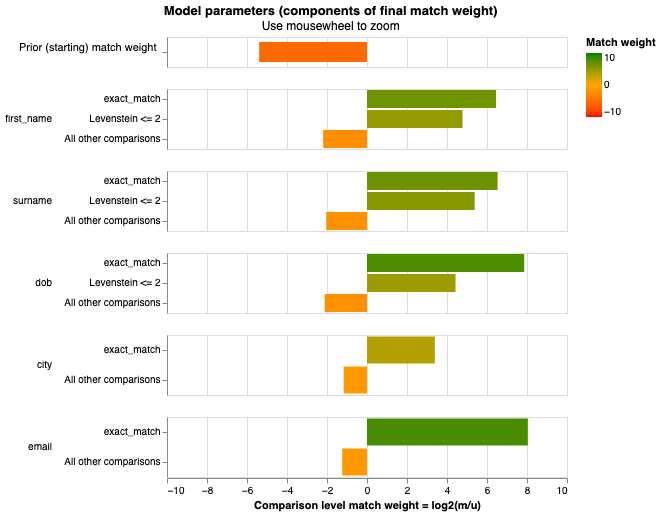

In [7]:
linker.match_weights_chart()